In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


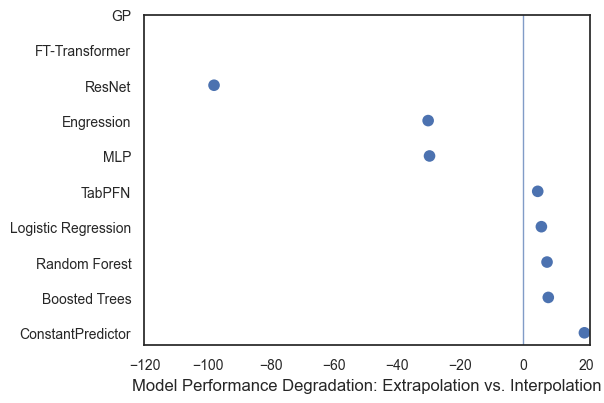

In [7]:
df = pd.read_csv("results_tabz.csv")
metric = "Accuracy"
df = df[df["metric"] == metric]

sns.set_theme(style="white", rc={"axes.grid": False})   

plt.rcParams.update({
    "figure.figsize": (6.2, 4.2),   # taller than 12x6
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})


# 1. Separate interpolation (ip) and extrapolation (ep) data
df_ip = df[df['split_method'] == "random_split"].copy()
df_ep = df[df['split_method'] != "random_split"].copy()

df_ip_baseline = df_ip[['task_id', 'model', 'value']].rename(columns={'value': 'metric_ip'})


merged_df = pd.merge(df_ep, df_ip_baseline, on=['task_id', 'model'])

merged_df['relative_difference'] = ( merged_df['metric_ip'] - merged_df['value']) / merged_df['metric_ip'] 
overall = (
    merged_df
    .groupby('model')['relative_difference']
    .mean()
    .reset_index(name='Mean')
)
overall['Mean'] *= 100  # Convert to percentage

method_order = [
    'ConstantPredictor', 'LogisticRegressor',
    'RandomForestClassifier', 'RandomForestRegressor',
    'LGBMClassifier', 'LGBMRegressor', 'Engression',
    'MLP', 'ResNet', 'FTTransformer', 'TabPFNClassifier', 'GPBoost_Accuracy'
]

present_models = overall['model'].unique()
method_order_filtered = [m for m in method_order if m in present_models]
overall = overall.set_index('model').reindex(method_order_filtered).reset_index()

rename_map = {
   'RandomForestClassifier':'Random Forest',
    'RandomForestRegressor':'Random Forest',
    'LGBMClassifier':       'Boosted Trees',
    'LGBMRegressor':        'Boosted Trees',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'LogisticRegressor':    'Logistic Regression',
    'TabPFNClassifier':     'TabPFN',
    'GPBoost_Accuracy': 'GP'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])

plot_df = overall.dropna(subset=['Mean']).copy()
plot_df = plot_df.sort_values('Mean', ascending=False)   # worst degradation at top

ypos = np.arange(len(plot_df))
fig, ax = plt.subplots()
ax.scatter(plot_df['Mean'].values, ypos, s=70,  edgecolors='none')

ax.set_yticks(ypos)
ax.set_yticklabels(plot_df['Method'])# top = larger % increase (worse under extrapolation)

ax.axvline(0, lw=1, alpha=0.7)

ax.set_xlabel("Model Performance Degradation: Extrapolation vs. Interpolation")
ax.set_ylabel("")


xmax = float(np.ceil(plot_df['Mean'].max() + 1))
ax.set_xlim(-120, xmax)

plt.tight_layout()
os.makedirs('PICTURES', exist_ok=True)
plt.savefig('PICTURES/ep_vs_ip_relative_difference_Accuracy_tabz.pdf', bbox_inches='tight')  # vector
plt.show()
plt.close()

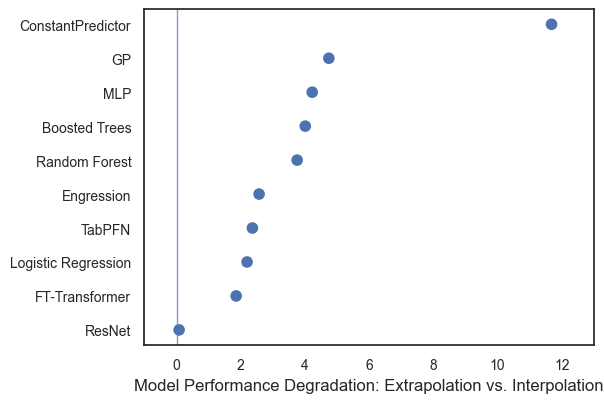

In [8]:

df = pd.read_csv("results_tabz.csv")
metric = "Accuracy"
df = df[df["metric"] == metric]


sns.set_theme(style="white", rc={"axes.grid": False})   

plt.rcParams.update({
    "figure.figsize": (6.2, 4.2),   # taller than 12x6
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# 1. Separate interpolation (ip) and extrapolation (ep) data
df_ip = df[df['split_method'] == "random_split"].copy()
df_ep = df[df['split_method'] != "random_split"].copy()

df_ip_baseline = df_ip[['task_id', 'model', 'value']].rename(columns={'value': 'metric_ip'})


merged_df = pd.merge(df_ep, df_ip_baseline, on=['task_id', 'model'])

merged_df['relative_difference'] = (merged_df['metric_ip'] - merged_df['value']) / merged_df['metric_ip']

overall = (
    merged_df
    .groupby('model')['relative_difference']
    .median()
    .reset_index(name='Median')
)
overall['Median'] *= 100  # Convert to percentage

method_order = [
    'ConstantPredictor', 'LogisticRegressor',
    'RandomForestClassifier', 'RandomForestRegressor',
    'LGBMClassifier', 'LGBMRegressor', 'Engression',
    'MLP', 'ResNet', 'FTTransformer', 'TabPFNClassifier', 'GPBoost_Accuracy'
]

present_models = overall['model'].unique()
method_order_filtered = [m for m in method_order if m in present_models]
overall = overall.set_index('model').reindex(method_order_filtered).reset_index()

rename_map = {
    'RandomForestClassifier':'Random Forest',
    'RandomForestRegressor':'Random Forest',
    'LGBMClassifier':       'Boosted Trees',
    'LGBMRegressor':        'Boosted Trees',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'LogisticRegressor':    'Logistic Regression',
    'TabPFNClassifier':     'TabPFN',
    'GPBoost_Accuracy': 'GP'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])

plot_df = overall.dropna(subset=['Median']).copy()
plot_df = plot_df.sort_values('Median', ascending=False)   # worst degradation at top

ypos = np.arange(len(plot_df))
fig, ax = plt.subplots()
ax.scatter(plot_df['Median'].values, ypos, s=70,  edgecolors='none')

ax.set_yticks(ypos)
ax.set_yticklabels(plot_df['Method'])
ax.invert_yaxis()  # top = larger % increase (worse under extrapolation)

# zero-reference line: right of 0 means extrapolation is worse than interpolation
ax.axvline(0, lw=1, alpha=0.7)

ax.set_xlabel("Model Performance Degradation: Extrapolation vs. Interpolation")
ax.set_ylabel("")

# dynamic x-limits (always include 0 and avoid clipping)
xmin = float(np.floor(min(0, plot_df['Median'].min()) - 1))
xmax = float(np.ceil(plot_df['Median'].max() + 1))
ax.set_xlim(xmin, xmax)

plt.tight_layout()
os.makedirs('PICTURES', exist_ok=True)
plt.savefig('PICTURES/ep_vs_ip_relative_difference_median_Accuracy_tabz.pdf', bbox_inches='tight')  # vector
plt.show()
plt.close()